In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft,fftfreq,ifft
from scipy import signal
from scipy.special import rel_entr
from sklearn.preprocessing import normalize
import librosa


In [210]:
def plot_fft(y,fs):
    N=len(y)
    T = 1/fs
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    plt.figure(figsize=(14,4))
    plt.scatter(xf, 2.0/N * np.abs(yf[0:N//2]))
    return

def minmax_normalize(data_set):
    data_normalized = (data_set-np.min(data_set))/(np.max(data_set)-np.min(data_set))
    return data_normalized

def standardize(data_set):
    data_normalize = (data_set-np.mean(data_set))/np.std(data_set)
    return data_normalize

def butter_bandpass(lowcut, highcut, fs, order=9):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=9):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def analyze(str_filename,Clean_space):


    df_0 = pd.read_csv(Clean_space)
    df = pd.read_csv(str_filename)
    fs = 62500.0
    T = 1/fs
    N= df.shape[0]
    y = np.array(df.Audio) - np.array(df_0.Audio)
    t = np.arange(0,N)*T


    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]

    #Band Pass filtering
    
    lowcut = 15000.0
    highcut = 19000.0

    b, a = butter_bandpass(lowcut, highcut, fs, order=12)
    w, h = signal.freqz(b, a, worN=30000)

    y_filtered_sound = butter_bandpass_filter(y, lowcut, highcut, fs, order=12)

    yf_filtered = fft(y_filtered_sound)
    xf_filtered = fftfreq(N, T)[:N//2]

    # Plot the frequency response and waveforms
    fig,ax = plt.subplots(4,1, figsize=(16,16))
    ax[0].plot(t, y)
    ax[0].title.set_text('Recieved Echo')

    ax[1].plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    ax[1].title.set_text('FFT of the Recieved Echo')

    ax[2].plot(t, y_filtered_sound)
    ax[2].title.set_text('BandPass filtered Recieved Echo')

    ax[3].plot(xf_filtered, 2.0/N * np.abs(yf_filtered[0:N//2]))
    ax[3].set_xlim((10000,22000))
    ax[3].title.set_text('FFT of BP-Recieved Echo')

    plt.show()

def butter_lowpass(cutoff, fs , order=4):
    nyq_freq = fs/2
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y  

def extract_peak_frequency(data, sampling_rate):
    fft_data = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(data))
    
    peak_coefficient = np.argmax(np.abs(fft_data))
    peak_freq = freqs[peak_coefficient]
    
    return abs(peak_freq * sampling_rate)

def Phase_lag_Hilbert(x1,x2,sampling_rate):
    
    x1h = signal.hilbert(x1)
    x2h = signal.hilbert(x2)
    omega = (extract_peak_frequency(x1,sampling_rate) + extract_peak_frequency(x2,sampling_rate))/2
             
    c = np.inner( x1h, np.conj(x2h) ) / np.sqrt( np.inner(x1h,np.conj(x1h)) * np.inner(x2h,np.conj(x2h)) )
    phase_diff = np.angle(c)/(np.pi*2*omega)
    return(-phase_diff * sampling_rate) # return the delayed number of sample points


def Phase_lag_xcc(A,B,sampling_rate):
    
    # Find cross-correlation
    xcorr = signal.correlate(A, B)
    lags = signal.correlation_lags(len(A), len(B))
    # delta time array to match xcorr
    omega = (extract_peak_frequency(A,sampling_rate) + extract_peak_frequency(B,sampling_rate))/2

    recovered_time_shift = lags[np.argmax(xcorr)]

    return(recovered_time_shift*(1/1000)*(np.pi*2*omega))

In [211]:
F_min = 18000 # 16KHz
F_max = 24000 # 20KHz
sampling_rate = 200000 # 384KHz
Fs = 200000  # 200KHz
FMCW_duration = 0.08
silent_duration = 0.02

In [212]:
#def normalize(x):
   # return(x)

In [213]:
sound,sr = librosa.load("TR 18-24_filtered.wav",sr=sampling_rate)

In [214]:
Tr_chirp =normalize([sound[:int(0.4*sampling_rate)]])[0]

In [215]:
def read_data(str_file_name):
    df = pd.read_csv(str_file_name)
    df=df.rename(columns={'Time':'time', 'Channel A':'ChnA', 'Channel B':'ChnB'})
    t = np.array(df.time[1:]).astype(float)
    Chn_A = np.array(df.ChnA[1:]).astype(float)
    Chn_B = np.array(df.ChnB[1:]).astype(float)
   
    return(t/1000 , Chn_A, Chn_B)

def get_data(filename):
    dA_1,dB_1 = np.array([]),np.array([])
    for i in range(1,3):
        s = str(i)
        file_name = filename + ".csv"
        time,A,B = read_data(file_name)
        dA_1,dB_1 = np.concatenate((dA_1,A)),np.concatenate((dB_1,B))
    return(dA_1,dB_1)

In [216]:
def segment_chirp(recieved_wave,fs):
    s = recieved_wave[int(0.3*fs):int(2*fs)]
    chirp_confirm=False
    su=0
    while(chirp_confirm==False):
        key = np.where(s>0.0015)[0][0]
        curr = key + int(0.12*fs)
        if (s[curr]>0.0015):
            curr = curr+int(0.12*fs)
            if (s[curr]>0.0015):
                curr = curr+int(0.22*fs)
                if (s[curr]>0.0015):
                    P = key + int(0.3*fs)
                    chirp_confirm=True
        curr = curr-int(0.06*fs)
        #print(curr)
        su=su+curr
        s=s[curr:]
    return(recieved_wave[P+su - int(0.02*fs): su+P+int(0.4*fs)])

In [217]:
Intfer_A_d,Intfer_B_d = get_data("Data_(18-24)\Ifer")

C:\Users\lshyamalma\AppData\Local\Temp\ipykernel_12728\3568509871.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(str_file_name)
C:\Users\lshyamalma\AppData\Local\Temp\ipykernel_12728\3568509871.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(str_file_name)


Text(0.5, 1.0, 'Transmitted (Interferance)')

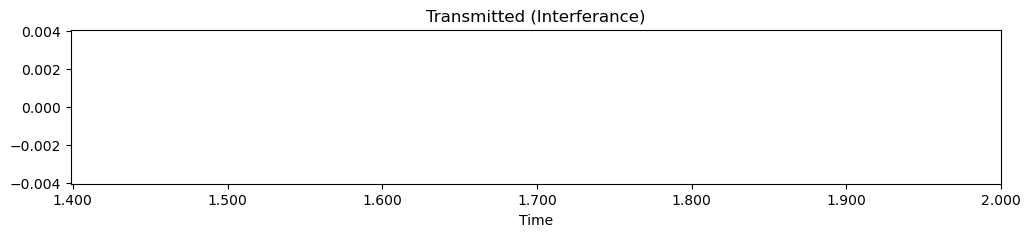

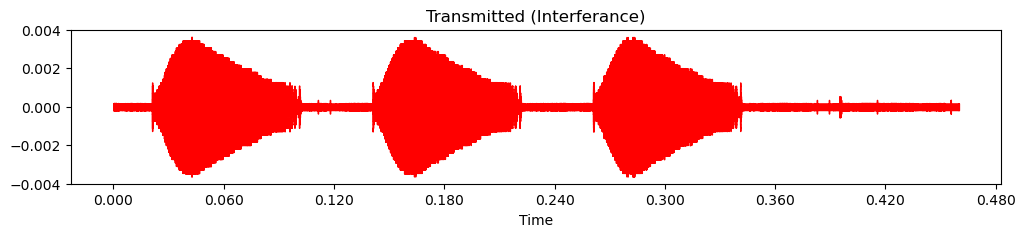

In [218]:
Intfer_A = normalize([Intfer_A_d])[0][int(Fs*1.379):int(Fs*(1.379+0.46))]
Intfer_B = normalize([Intfer_B_d])[0][int(Fs*1.379):int(Fs*(1.379+0.46))]

plt.figure(figsize=(12,2))
librosa.display.waveshow(Intfer_A,sr=Fs,color="blue")
plt.title("Transmitted (Interferance)")
plt.xlim((1.399,2))

plt.figure(figsize=(12,2))
librosa.display.waveshow(Intfer_B,sr=Fs,color="red")
plt.title("Transmitted (Interferance)")
#plt.xlim((0.49,0.89))

In [219]:
Tes_no = "0"
ref_A0d , ref_B0d = get_data("Data_(18-24)\Test 0\Ref")

Ref_A_1_d,Ref_B_1_d = get_data("Data_(18-24)\Test "+Tes_no+"\Ref")
Relax_Ad,Relax_Bd = get_data("Data_(18-24)\Test "+Tes_no+"\Close")
OpM_Ad,OpM_Bd = get_data("Data_(18-24)\Test "+Tes_no+"\Open")
Blow_Ad,Blow_Bd = get_data("Data_(18-24)\Test "+Tes_no+"\Lagh")
Side_Ad , Side_Bd = get_data("Data_(18-24)\Test "+Tes_no+"\Side")
#umpa,lumpa = get_data("Test 9\Open\Open_")

C:\Users\lshyamalma\AppData\Local\Temp\ipykernel_12728\3568509871.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(str_file_name)
C:\Users\lshyamalma\AppData\Local\Temp\ipykernel_12728\3568509871.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(str_file_name)
C:\Users\lshyamalma\AppData\Local\Temp\ipykernel_12728\3568509871.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(str_file_name)
C:\Users\lshyamalma\AppData\Local\Temp\ipykernel_12728\3568509871.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(str_file_name)
C:\Users\lshyamalma\AppData\Local\Temp\ipykernel_12728\3568509871.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set lo

In [220]:
ref_A0 = normalize([ref_A0d])[0][int(Fs*1.207):int(Fs*(1.207+0.46))]
ref_B0 = normalize([ref_B0d])[0][int(Fs*1.207):int(Fs*(1.207+0.46))]

Text(0.5, 1.0, 'Referance Echo')

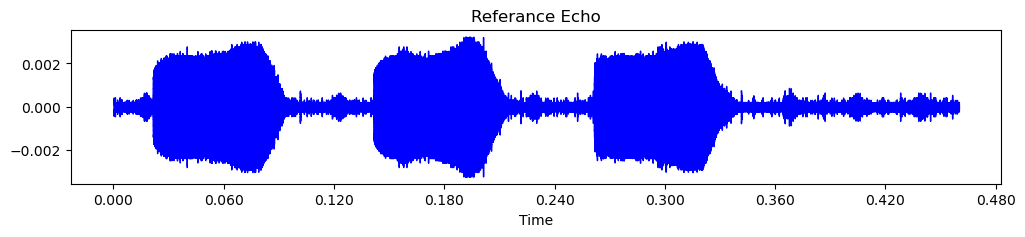

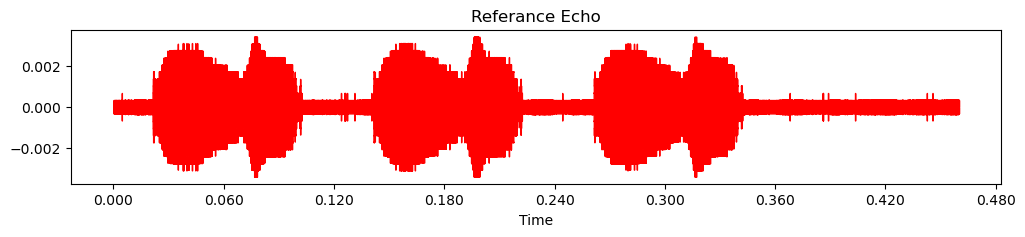

In [221]:
Ref_A_1 = normalize([Ref_A_1_d])[0][int(Fs*1.207):int(Fs*(1.207+0.46))]
Ref_B_1 = normalize([Ref_B_1_d])[0][int(Fs*1.207):int(Fs*(1.207+0.46))]
#[int(Fs*0.95):int(Fs*1.35)]
plt.figure(figsize=(12,2))
librosa.display.waveshow(Ref_A_1,sr=Fs,color="blue")
plt.title("Referance Echo")
#plt.xlim((1.227,2))

plt.figure(figsize=(12,2))
librosa.display.waveshow(Ref_B_1,sr=Fs,color="red")
plt.title("Referance Echo")
#plt.xlim((0.49,0.89))



Text(0.5, 1.0, 'No expression')

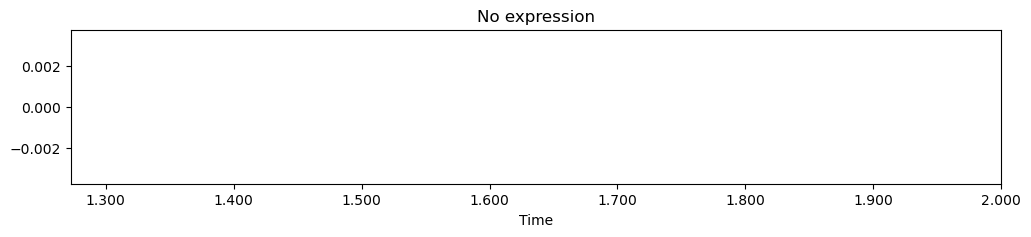

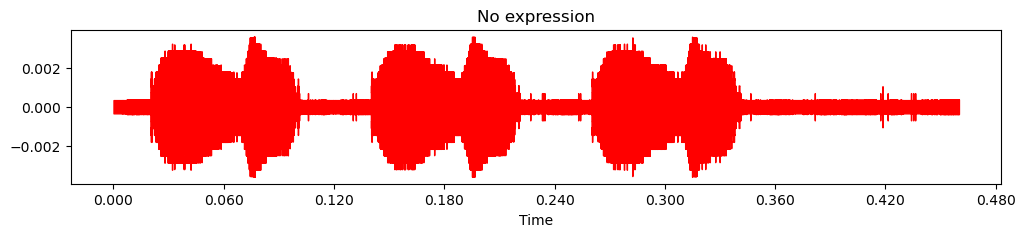

In [222]:
Relax_A = normalize([Relax_Ad])[0][int(Fs*1.254):int(Fs*(1.254+0.46))]
Relax_B = normalize([Relax_Bd])[0][int(Fs*1.254):int(Fs*(1.254+0.46))]
#[int(Fs*0.438):int(Fs*0.838)]
plt.figure(figsize=(12,2))
librosa.display.waveshow(Relax_A,sr=Fs,color="blue")
plt.title("No expression")
plt.xlim((1.273,2))

plt.figure(figsize=(12,2))
librosa.display.waveshow(Relax_B,sr=Fs,color="red")
plt.title("No expression")
#plt.xlim((0.7305,1.122))

Text(0.5, 1.0, 'Open Mouth')

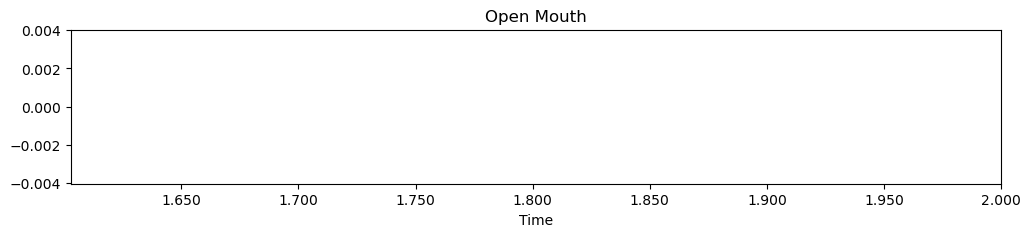

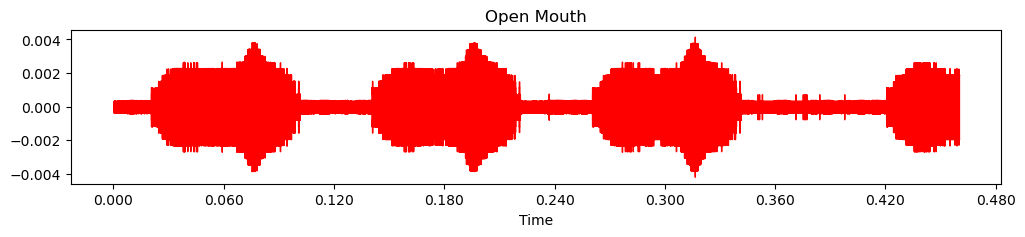

In [223]:
OpM_A = normalize([OpM_Ad])[0][int(Fs*1.583):int(Fs*(1.583+0.46))]
OpM_B = normalize([OpM_Bd])[0][int(Fs*1.583):int(Fs*(1.583+0.46))]

plt.figure(figsize=(12,2))
librosa.display.waveshow(OpM_A,sr=Fs,color="blue")
plt.title("Open Mouth")
plt.xlim((1.603,2))

plt.figure(figsize=(12,2))
librosa.display.waveshow(OpM_B,sr=Fs,color="red")
plt.title("Open Mouth")
#plt.xlim((2.29,3))

Text(0.5, 1.0, 'Blow')

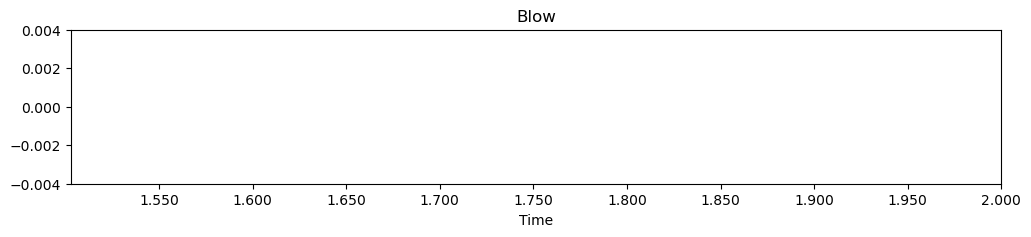

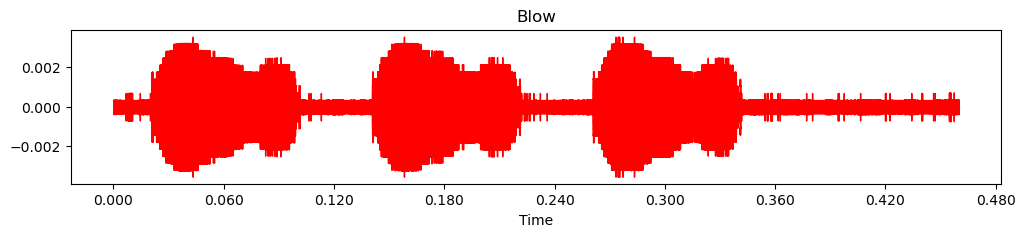

In [224]:
Blow_A = normalize([Blow_Ad])[0][int(Fs*1.483):int(Fs*(1.483+0.46))]
Blow_B = normalize([Blow_Bd])[0][int(Fs*1.483):int(Fs*(1.483+0.46))]

plt.figure(figsize=(12,2))
librosa.display.waveshow(Blow_A,sr=Fs,color="blue")
plt.title("Blow")
plt.xlim((1.503,2))

plt.figure(figsize=(12,2))
librosa.display.waveshow(Blow_B,sr=Fs,color="red")
plt.title("Blow")
#plt.xlim((0.49,0.89))

Text(0.5, 1.0, 'Side')

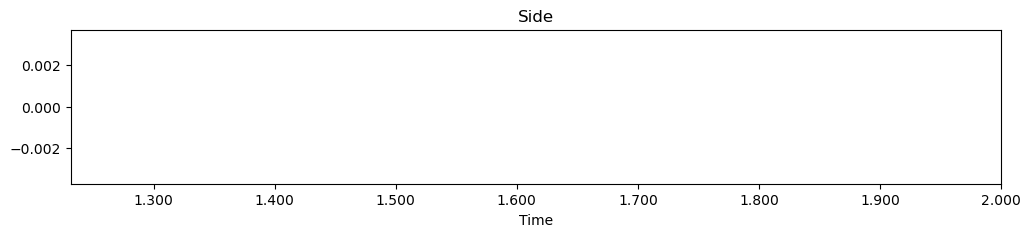

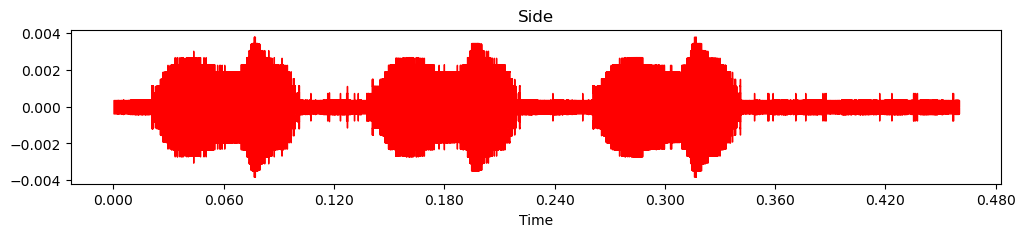

In [225]:
Side_A = normalize([Side_Ad])[0][int(Fs*1.212):int(Fs*(1.212+0.46))]
Side_B = normalize([Side_Bd])[0][int(Fs*1.212):int(Fs*(1.212+0.46))]

plt.figure(figsize=(12,2))
librosa.display.waveshow(Side_A,sr=Fs,color="blue")
plt.title("Side")
plt.xlim((1.232,2))

plt.figure(figsize=(12,2))
librosa.display.waveshow(Side_B,sr=Fs,color="red")
plt.title("Side")
#plt.xlim((0.49,0.89))

In [226]:
def Additionally_average(data_set,fs):
    fs = int(fs)
    averaged_data = data_set[: int(0.120*fs)]

    for i in range(1,3):
     
        averaged_data= averaged_data + data_set[int((0.120*i)*fs) : int((0.120*(i+1))*fs)]
    return(averaged_data.astype(float))

Intfer_A , Intfer_B= Additionally_average(Intfer_A,Fs) , Additionally_average(Intfer_B,Fs)
ref_A0 , ref_B0 = Additionally_average(ref_A0,Fs) , Additionally_average(ref_B0,Fs)
 
Ref_A_1 , Ref_B_1 = Additionally_average(Ref_A_1,Fs) , Additionally_average(Ref_B_1,Fs)
Relax_A , Relax_B = Additionally_average(Relax_A,Fs) , Additionally_average(Relax_B,Fs)
OpM_A , OpM_B =     Additionally_average(OpM_A,Fs) , Additionally_average(OpM_B,Fs)
Blow_A , Blow_B =   Additionally_average(Blow_A,Fs) , Additionally_average(Blow_B,Fs)
Side_A , Side_B =   Additionally_average(Side_A,Fs) , Additionally_average(Side_B,Fs)
Tr_chirp = Additionally_average(Tr_chirp,Fs)

Filtering

In [227]:
filt_Tr_chirp = butter_bandpass_filter(Tr_chirp,F_min,F_max,Fs,order=9)

filt_ref_A0 , filt_ref_B0 = butter_bandpass_filter(ref_A0,F_min,F_max,Fs,order=9) , butter_bandpass_filter(ref_B0,F_min,F_max,Fs,order=9)

filt_IF_A , filt_IF_B = butter_bandpass_filter(Intfer_A,F_min,F_max,Fs,order=9),butter_bandpass_filter(Intfer_B,F_min,F_max,Fs,order=9)
filt_Ref_A , filt_Ref_B = butter_bandpass_filter(Ref_A_1,F_min,F_max,Fs,order=9),butter_bandpass_filter(Ref_B_1,F_min,F_max,Fs,order=9)
filt_Relax_A ,filt_Relax_B  = butter_bandpass_filter(Relax_A,F_min,F_max,Fs,order=9) , butter_bandpass_filter(Relax_B,F_min,F_max,Fs,order=9)
filt_OpM_A ,filt_OpM_B  = butter_bandpass_filter(OpM_A,F_min,F_max,Fs,order=9) , butter_bandpass_filter(OpM_B,F_min,F_max,Fs,order=9)
filt_Blow_A ,filt_Blow_B  = butter_bandpass_filter(Blow_A,F_min,F_max,Fs,order=9) , butter_bandpass_filter(Blow_B,F_min,F_max,Fs,order=9)
filt_Side_A ,filt_Side_B  = butter_bandpass_filter(Side_A,F_min,F_max,Fs,order=9) , butter_bandpass_filter(Side_B,F_min,F_max,Fs,order=9)

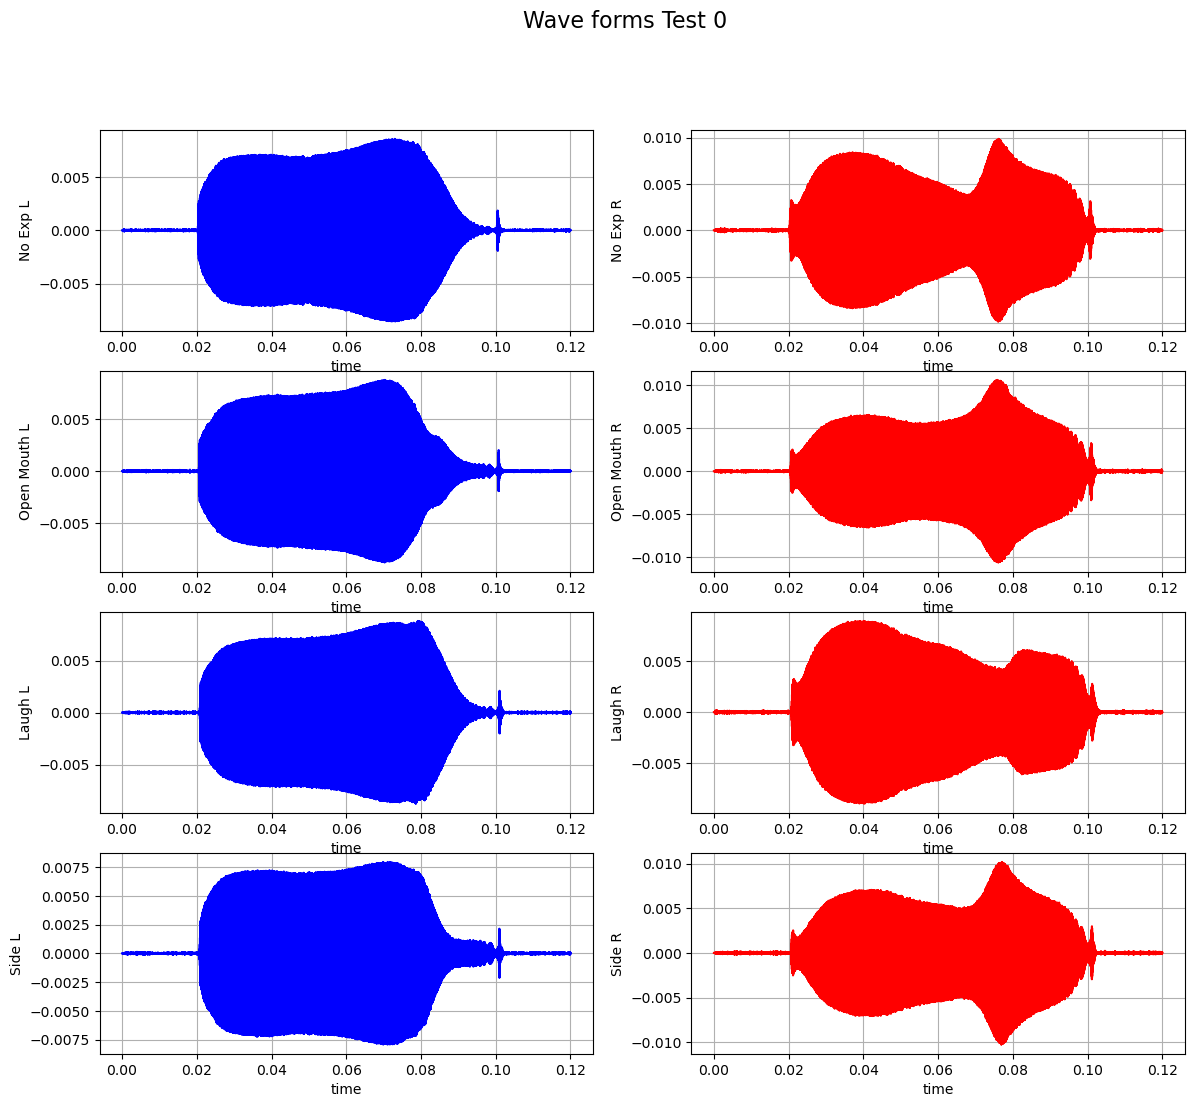

In [228]:
t = np.linspace(0,0.12,int(0.12*Fs))

fig, axs = plt.subplots(4, 2,figsize=(14,12))
fig.suptitle('Wave forms Test '+Tes_no, fontsize=16)

axs[0,0].plot(t,filt_Relax_A,color="blue")
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('No Exp L')
axs[0,0].grid(True)

axs[0,1].plot(t,filt_Relax_B,color="red")
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('No Exp R')
axs[0,1].grid(True)

axs[1,0].plot(t,filt_OpM_A,color="blue")
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('Open Mouth L')
axs[1,0].grid(True)

axs[1,1].plot(t,filt_OpM_B,color="red")
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('Open Mouth R')
axs[1,1].grid(True)

axs[2,0].plot(t,filt_Blow_A,color="blue")
axs[2,0].set_xlabel('time')
axs[2,0].set_ylabel('Laugh L')
axs[2,0].grid(True)

axs[2,1].plot(t,filt_Blow_B,color="red")
axs[2,1].set_xlabel('time')
axs[2,1].set_ylabel('Laugh R')
axs[2,1].grid(True)

axs[3,0].plot(t,filt_Side_A,color="blue")
axs[3,0].set_xlabel('time')
axs[3,0].set_ylabel('Side L')
axs[3,0].grid(True)

axs[3,1].plot(t,filt_Side_B,color="red")
axs[3,1].set_xlabel('time')
axs[3,1].set_ylabel('Side R')
axs[3,1].grid(True)

plt.savefig("Results\Wave form "+Tes_no+".png")

plt.show()

(15000.0, 27000.0)

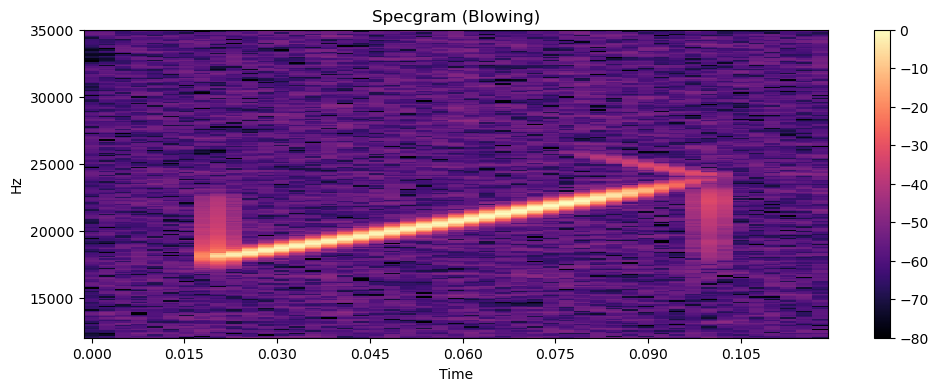

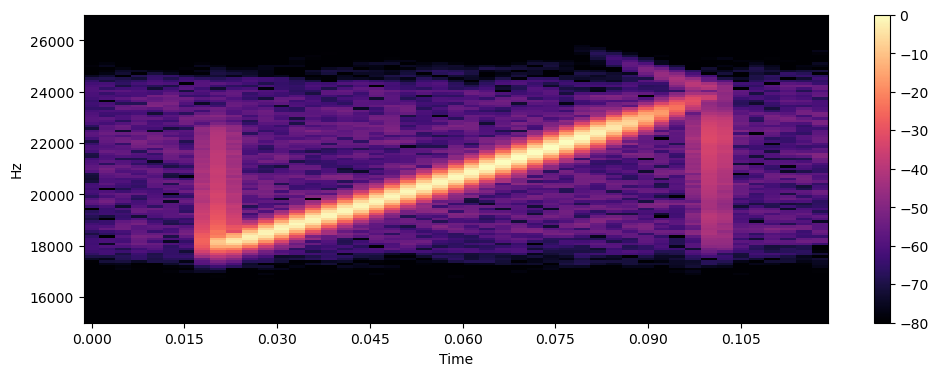

In [229]:
Xf_A = librosa.amplitude_to_db(np.abs(librosa.stft(Relax_A)), ref=np.max)
plt.figure(figsize=(12,4))
img = librosa.display.specshow(Xf_A, y_axis='linear', x_axis='time',sr=Fs)                         
plt.colorbar()
plt.ylim((12000,35000))
plt.title("Specgram (Blowing)")
#plt.xlim((0,1))

Xf_B = librosa.amplitude_to_db(np.abs(librosa.stft(filt_Relax_A)), ref=np.max)
plt.figure(figsize=(12,4))
img = librosa.display.specshow(Xf_B, y_axis='linear', x_axis='time',sr=Fs)                         
plt.colorbar()
plt.ylim((15000,27000))
#plt.xlim((0,1))

TF Modeling

In [230]:
T= 1/Fs
N=len(filt_Relax_A)

fifa , fifb = fft(filt_IF_A) , fft(filt_IF_B)

F_ref_A0 , F_ref_B0 = fft(filt_ref_A0) , fft(filt_ref_B0)

F_ref_A , F_ref_B = fft(filt_Ref_A) , fft(filt_Ref_B)
F_relax_A , F_relax_B = fft(filt_Relax_A) , fft(filt_Relax_B)
F_OpM_A , F_OpM_B = fft(filt_OpM_A) , fft(filt_OpM_B)
F_Blow_A , F_Blow_B = fft(filt_Blow_A) , fft(filt_Blow_B)
F_Side_A , F_Side_B = fft(filt_Side_A) , fft(filt_Side_B)
Transmit_f = fft(Tr_chirp)

X_f = fftfreq(N,T)
xf = fftfreq(N, T)[:N//2]


def get_TF(signalA_fft,signalB_fft):

    A , B = F_ref_A/F_ref_A0 , F_ref_B/F_ref_B0

    tfA= ((signalA_fft/A) -fifa) / Transmit_f

    tfB = ((signalB_fft/B) - fifb ) / Transmit_f

    return(tfA,tfB)


TF_relax_A , TF_relax_B   = get_TF(F_relax_A,F_relax_B)
  

TF_Side_A , TF_Side_B    = get_TF(F_Side_A ,F_Side_B)


TF_OpM_A , TF_OpM_B = get_TF(F_OpM_A  ,F_OpM_B )


TF_Blow_A ,TF_Blow_B = get_TF(F_Blow_A ,F_Blow_B ) 


Left Ear

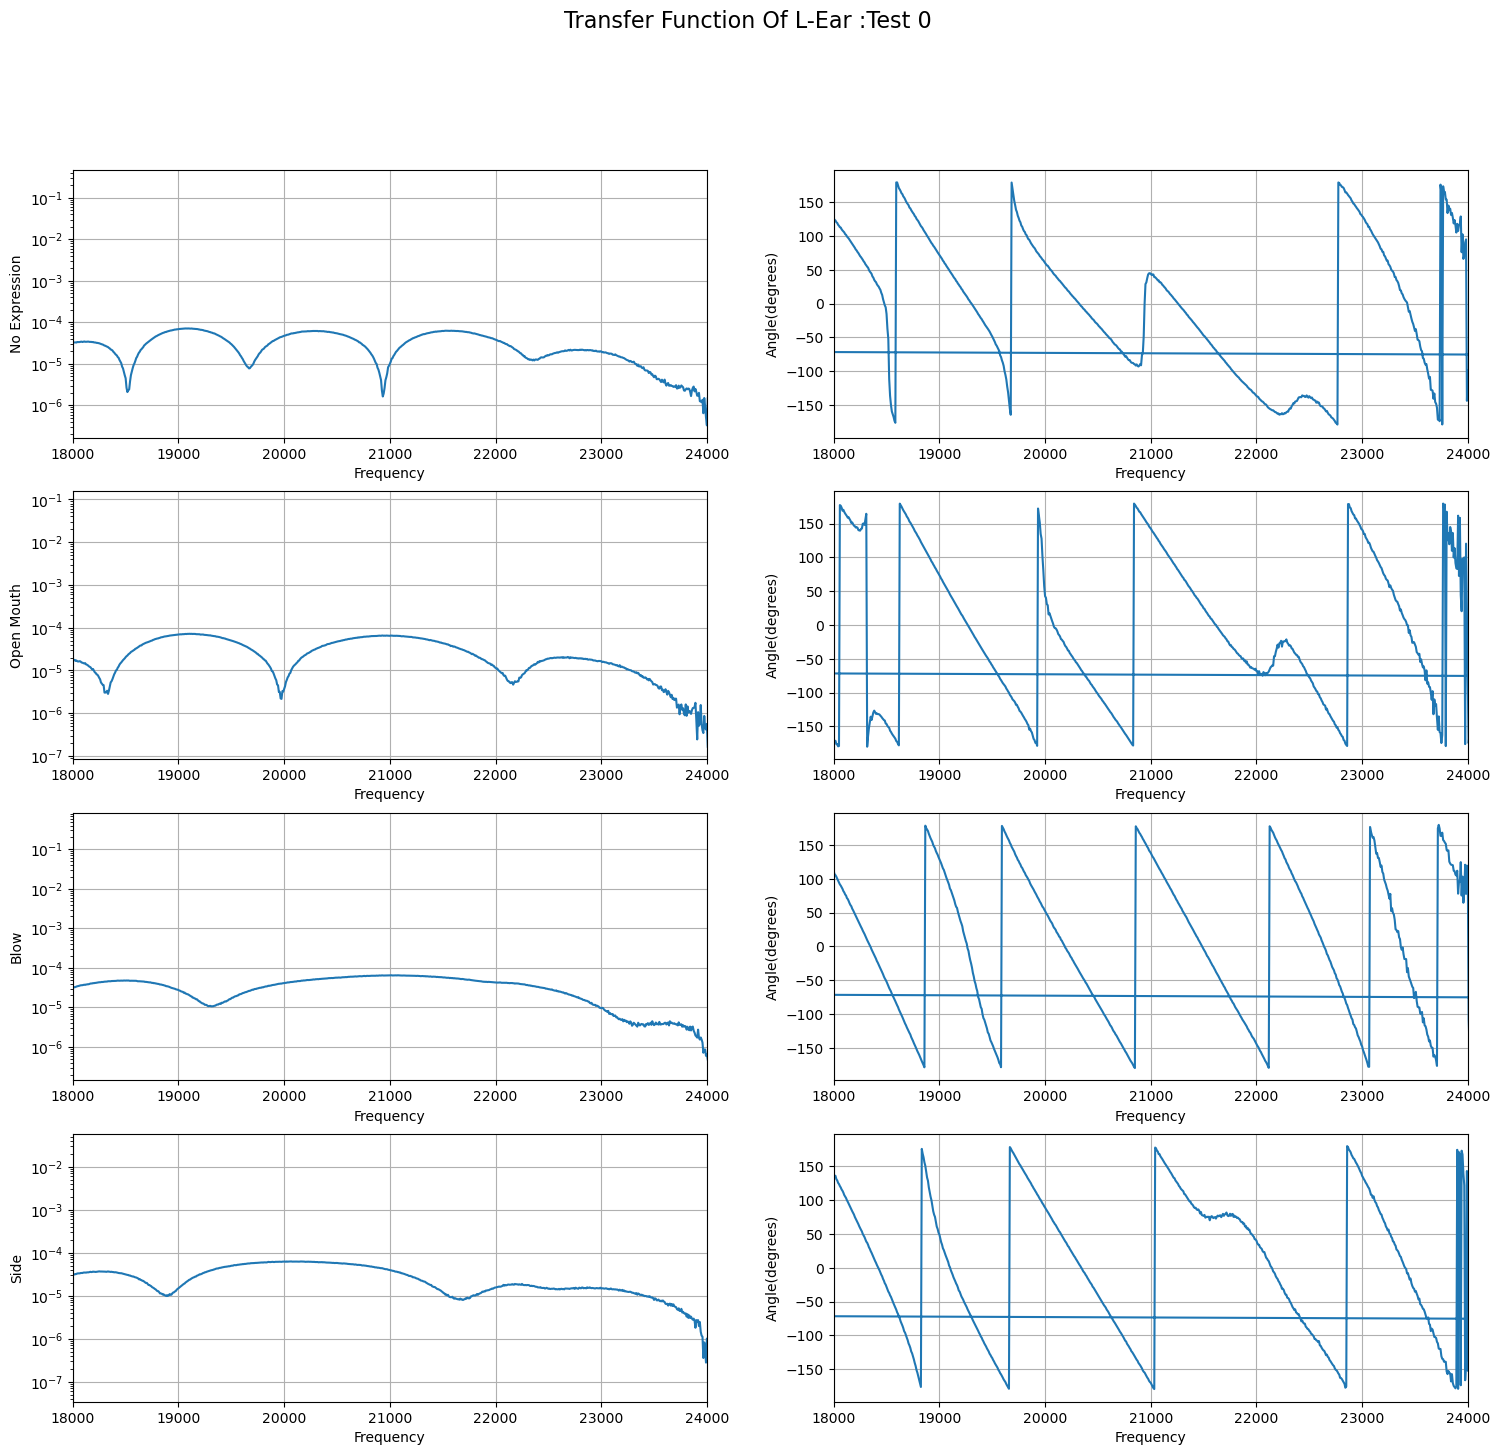

In [231]:

fig, axs = plt.subplots(4, 2,figsize=(18,16))
fig.suptitle('Transfer Function Of L-Ear :Test '+Tes_no, fontsize=16)

axs[0,0].semilogy(xf,(2/N)*abs(TF_relax_A[:N//2]))
axs[0,0].set_xlim((F_min,F_max))
axs[0,0].set_xlabel('Frequency')
axs[0,0].set_ylabel('No Expression')
axs[0,0].grid(True)

axs[0,1].plot(X_f,(180/np.pi)*np.angle(TF_relax_A))
axs[0,1].set_xlim((F_min,F_max))
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_ylabel('Angle(degrees)')
axs[0,1].grid(True)

axs[1,0].semilogy(xf,(2/N)*abs(TF_OpM_A[:N//2]))
axs[1,0].set_xlim((F_min,F_max))
axs[1,0].set_xlabel('Frequency')
axs[1,0].set_ylabel('Open Mouth')
axs[1,0].grid(True)

axs[1,1].plot(X_f,(180/np.pi)*np.angle(TF_OpM_A))
axs[1,1].set_xlim((F_min,F_max))
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_ylabel('Angle(degrees)')
axs[1,1].grid(True)

axs[2,0].semilogy(xf,(2/N)*abs(TF_Blow_A[:N//2]))
axs[2,0].set_xlim((F_min,F_max))
axs[2,0].set_xlabel('Frequency')
axs[2,0].set_ylabel('Blow')
axs[2,0].grid(True)

axs[2,1].plot(X_f,(180/np.pi)*np.angle(TF_Blow_A))
axs[2,1].set_xlim((F_min,F_max))
axs[2,1].set_xlabel('Frequency')
axs[2,1].set_ylabel('Angle(degrees)')
axs[2,1].grid(True)

axs[3,0].semilogy(xf,(2/N)*abs(TF_Side_A[:N//2]))
axs[3,0].set_xlim((F_min,F_max))
axs[3,0].set_xlabel('Frequency')
axs[3,0].set_ylabel('Side')
axs[3,0].grid(True)

axs[3,1].plot(X_f,(180/np.pi)*np.angle(TF_Side_A))
axs[3,1].set_xlim((F_min,F_max))
axs[3,1].set_xlabel('Frequency')
axs[3,1].set_ylabel('Angle(degrees)')
axs[3,1].grid(True)

plt.savefig("Results\TF_L "+Tes_no+".png")

plt.show()


Right Ear

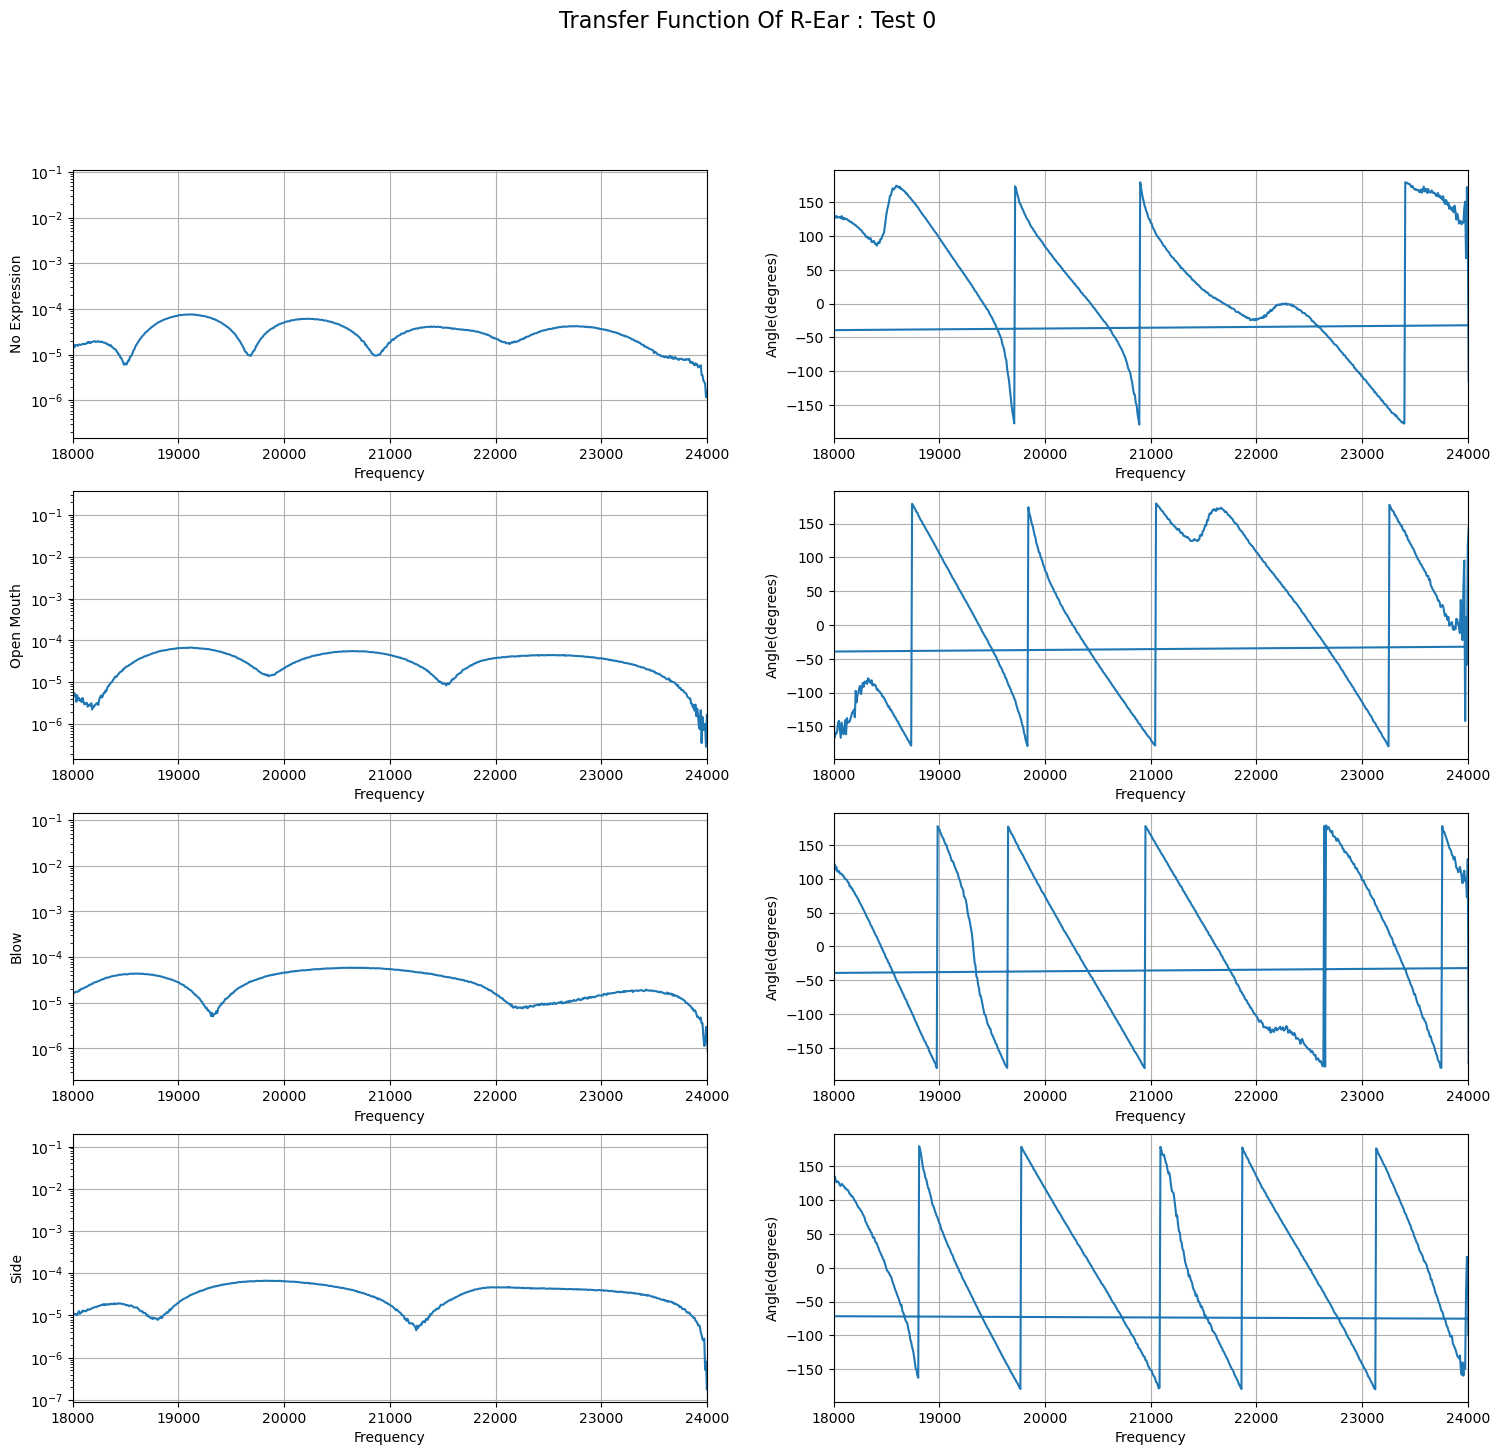

In [232]:
fig, axs = plt.subplots(4, 2,figsize=(18,16))
fig.suptitle('Transfer Function Of R-Ear : Test '+Tes_no, fontsize=16)

axs[0,0].semilogy(xf,(2/N)*abs(TF_relax_B[:N//2]))
axs[0,0].set_xlim((F_min,F_max))
axs[0,0].set_xlabel('Frequency')
axs[0,0].set_ylabel('No Expression')
axs[0,0].grid(True)

axs[0,1].plot(X_f,(180/np.pi)*np.angle(TF_relax_B))
axs[0,1].set_xlim((F_min,F_max))
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_ylabel('Angle(degrees)')
axs[0,1].grid(True)

axs[1,0].semilogy(xf,(2/N)*abs(TF_OpM_B[:N//2]))
axs[1,0].set_xlim((F_min,F_max))
axs[1,0].set_xlabel('Frequency')
axs[1,0].set_ylabel('Open Mouth')
axs[1,0].grid(True)

axs[1,1].plot(X_f,(180/np.pi)*np.angle(TF_OpM_B))
axs[1,1].set_xlim((F_min,F_max))
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_ylabel('Angle(degrees)')
axs[1,1].grid(True)

axs[2,0].semilogy(xf,(2/N)*abs(TF_Blow_B[:N//2]))
axs[2,0].set_xlim((F_min,F_max))
axs[2,0].set_xlabel('Frequency')
axs[2,0].set_ylabel('Blow')
axs[2,0].grid(True)

axs[2,1].plot(X_f,(180/np.pi)*np.angle(TF_Blow_B))
axs[2,1].set_xlim((F_min,F_max))
axs[2,1].set_xlabel('Frequency')
axs[2,1].set_ylabel('Angle(degrees)')
axs[2,1].grid(True)

axs[3,0].semilogy(xf,(2/N)*abs(TF_Side_B[:N//2]))
axs[3,0].set_xlim((F_min,F_max))
axs[3,0].set_xlabel('Frequency')
axs[3,0].set_ylabel('Side')
axs[3,0].grid(True)

axs[3,1].plot(X_f,(180/np.pi)*np.angle(TF_Side_B))
axs[3,1].set_xlim((F_min,F_max))
axs[3,1].set_xlabel('Frequency')
axs[3,1].set_ylabel('Angle(degrees)')
axs[3,1].grid(True)

plt.savefig("Results\TF_R "+Tes_no+".png")

plt.show()

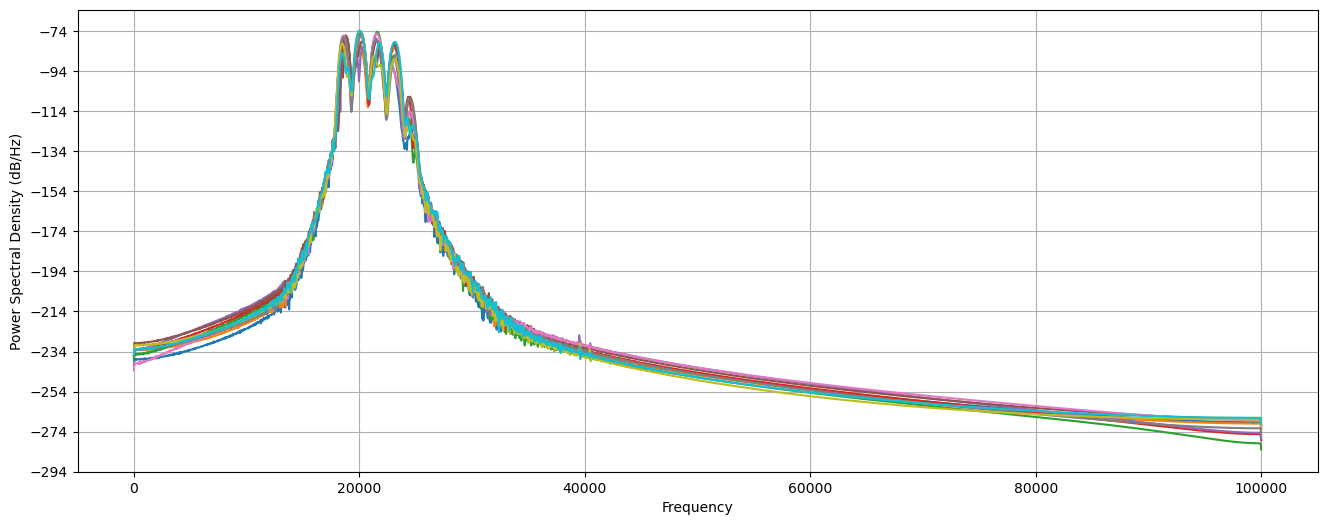

In [233]:
plt.figure(figsize=(16,6))
#psd_transmit=plt.psd(Tr_chirp,NFFT=4096,Fs=Fs)
#psd_transmit = plt.psd(Tr_chirp,NFFT=4096,Fs=Fs)
psd_ref_A , psd_ref_B = plt.psd(filt_Ref_A,NFFT=4096,Fs=Fs) , plt.psd(filt_Ref_B,NFFT=4096,Fs=Fs)

psd_Relax_A , psd_Relax_B = plt.psd(filt_Relax_A- filt_IF_A ,NFFT=4096,Fs=Fs) , plt.psd(filt_Relax_B-filt_IF_B,NFFT=4096,Fs=Fs)

psd_OpM_A , psd_OpM_B = plt.psd(filt_OpM_A- filt_IF_A,NFFT=4096,Fs=Fs) , plt.psd(filt_OpM_B-filt_IF_B,NFFT=4096,Fs=Fs)

psd_Blow_A , psd_Blow_B = plt.psd(filt_Blow_A- filt_IF_A,NFFT=4096,Fs=Fs) , plt.psd(filt_Blow_B-filt_IF_B,NFFT=4096,Fs=Fs)

psd_Side_A , psd_Side_B = plt.psd(filt_Side_A- filt_IF_A,NFFT=4096,Fs=Fs) , plt.psd(filt_Side_B-filt_IF_B,NFFT=4096,Fs=Fs)
#plt.xlim((16000,22000))

In [234]:
freq_A , freq_B = psd_ref_A[1][327:452] , psd_ref_B[1][327:452]
#psd_transmit = psd_transmit[0][327:452] 
psd_ref_A , psd_ref_B = psd_ref_A[0][327:452] , psd_ref_B[0][327:452]
psd_Relax_A , psd_Relax_B = psd_Relax_A[0][327:452] , psd_Relax_B[0][327:452]
psd_OpM_A , psd_OpM_B = psd_OpM_A[0][327:452] , psd_OpM_B[0][327:452]
psd_Blow_A , psd_Blow_B = psd_Blow_A[0][327:452] , psd_Blow_B[0][327:452]
psd_Side_A , psd_Side_B = psd_Side_A[0][327:452] , psd_Side_B[0][327:452]

In [235]:
def TF_from_PSD(signalA, signalB):
    psd_A , psd_B = plt.psd(signalA,NFFT=4096,Fs=Fs) , plt.psd(signalB,NFFT=4096,Fs=Fs)

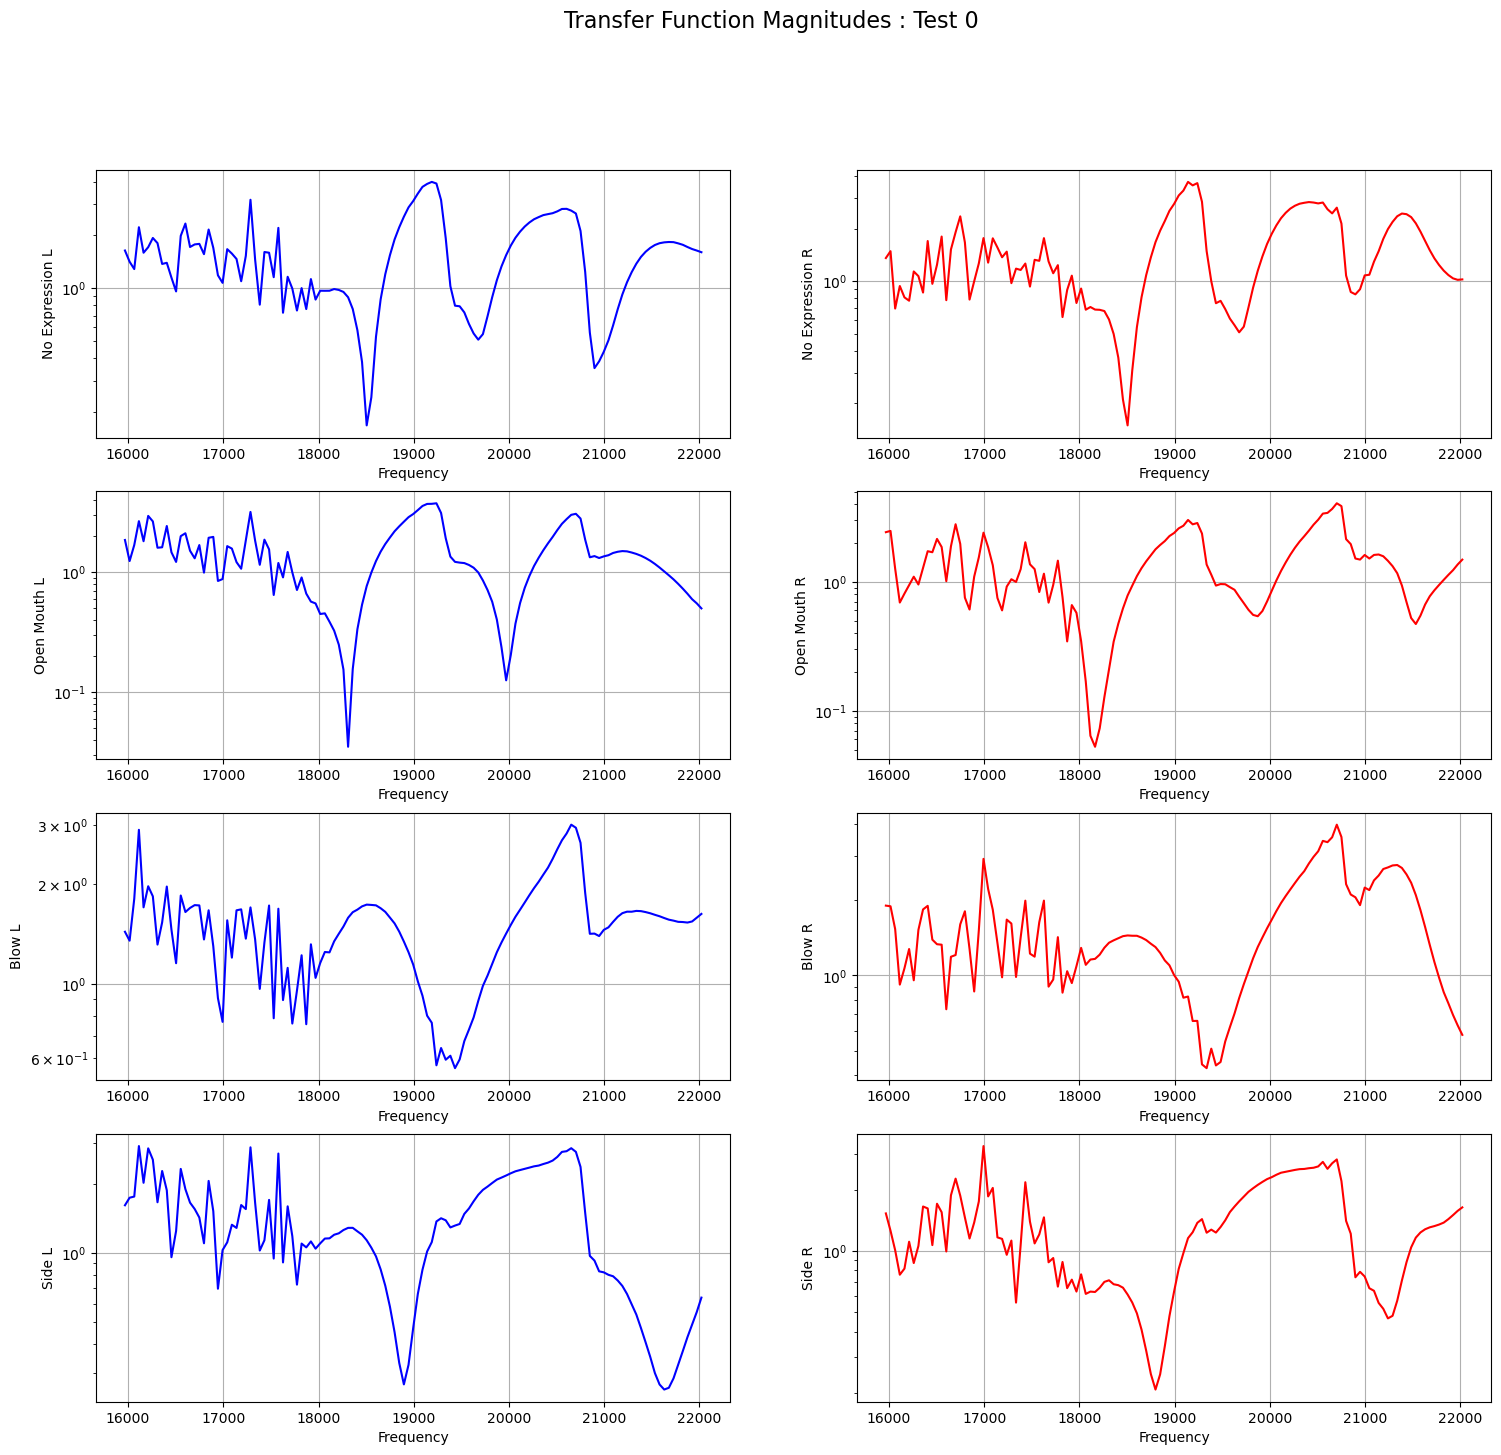

In [236]:
psd_tf_relax_A , psd_tf_relax_B = np.sqrt((psd_Relax_A)/psd_ref_A) , np.sqrt((psd_Relax_B)/psd_ref_B)
psd_tf_Opm_A , psd_tf_Opm_B =   np.sqrt((psd_OpM_A)/psd_ref_A) , np.sqrt((psd_OpM_B)/psd_ref_B)
psd_tf_blow_A , psd_tf_blow_B =  np.sqrt((psd_Blow_A)/psd_ref_A) , np.sqrt((psd_Blow_B)/psd_ref_B)
psd_tf_side_A , psd_tf_side_B =  np.sqrt((psd_Side_A)/psd_ref_A) , np.sqrt((psd_Side_B)/psd_ref_B)

fig, axs = plt.subplots(4, 2,figsize=(18,16))
fig.suptitle('Transfer Function Magnitudes : Test '+Tes_no, fontsize=16)

axs[0,0].semilogy(freq_A, psd_tf_relax_A , color="blue")
#axs[0,0].set_xlim((16000,22000))
axs[0,0].set_xlabel('Frequency')
axs[0,0].set_ylabel('No Expression L')
axs[0,0].grid(True)

axs[0,1].semilogy(freq_B , psd_tf_relax_B  , color="red")
#axs[0,1].set_xlim((16000,22000))
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_ylabel('No Expression R')
axs[0,1].grid(True)

axs[1,0].semilogy(freq_A , psd_tf_Opm_A , color="blue")
#axs[1,0].set_xlim((16000,22000))
axs[1,0].set_xlabel('Frequency')
axs[1,0].set_ylabel('Open Mouth L')
axs[1,0].grid(True)

axs[1,1].semilogy(freq_B,psd_tf_Opm_B , color="red")
#axs[1,1].set_xlim((16000,22000))
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_ylabel('Open Mouth R')
axs[1,1].grid(True)

axs[2,0].semilogy(freq_A , psd_tf_blow_A  , color="blue")
#axs[2,0].set_xlim((16000,22000))
axs[2,0].set_xlabel('Frequency')
axs[2,0].set_ylabel('Blow L')
axs[2,0].grid(True)

axs[2,1].semilogy(freq_B , psd_tf_blow_B , color="red")
#axs[2,1].set_xlim((16000,22000))
axs[2,1].set_xlabel('Frequency')
axs[2,1].set_ylabel('Blow R')
axs[2,1].grid(True)

axs[3,0].semilogy(freq_A , psd_tf_side_A  , color="blue")
#axs[2,0].set_xlim((16000,22000))
axs[3,0].set_xlabel('Frequency')
axs[3,0].set_ylabel('Side L')
axs[3,0].grid(True)

axs[3,1].semilogy(freq_B , psd_tf_side_B , color="red")
#axs[2,1].set_xlim((16000,22000))
axs[3,1].set_xlabel('Frequency')
axs[3,1].set_ylabel('Side R')
axs[3,1].grid(True)

In [237]:
kl_noexp = [sum(rel_entr(psd_tf_relax_A,psd_tf_relax_A)) , sum(rel_entr(psd_tf_relax_B,psd_tf_relax_B))]
kl_Opm = [sum(rel_entr(psd_tf_relax_A,psd_tf_Opm_A)) , sum(rel_entr(psd_tf_relax_B,psd_tf_Opm_B))]
kl_blow = [sum(rel_entr(psd_tf_relax_A,psd_tf_blow_A)) , sum(rel_entr(psd_tf_relax_B,psd_tf_blow_B))]
kl_side = [sum(rel_entr(psd_tf_relax_A,psd_tf_side_A)) , sum(rel_entr(psd_tf_relax_B,psd_tf_side_B))]

In [238]:
print("--------- Test_No :" , Tes_no)
print("KL Divergance : NoExp - Open Mouth " , kl_Opm)
print("KL Divergance : NoExp - Lagh " , kl_blow)
print("KL Divergance : NoExp - Side " , kl_side)


--------- Test_No : 0
KL Divergance : NoExp - Open Mouth  [46.59742027887292, 39.38937277456891]
KL Divergance : NoExp - Lagh  [42.20147693725051, 24.224423950233053]
KL Divergance : NoExp - Side  [79.77675866660849, 62.63531136067572]
